Evaluate neuroverse3D on subtasks 


In [1]:
# write demo file to the analysis folder and import to nora project

import shutil
import subprocess
from pathlib import Path
from src.config import config

# file paths
origin_image_dir = Path('/software/notebooks/camaret/repos/Neuroverse3D/Demo_data/seg/imgs/')
origin_label_dir = Path('/software/notebooks/camaret/repos/Neuroverse3D/Demo_data/seg/labs/')

# Project settings
project_name = "camaret___in_context_segmentation"
patient_id = "neuroverse3ddemo"

# Create import directory
import_dir = Path(config["RESULTS_DIR"]) / patient_id
import_dir.mkdir(exist_ok=True)
img_dir = import_dir / 'imgs'
lab_dir = import_dir / 'labs'
img_dir.mkdir(exist_ok=True)
lab_dir.mkdir(exist_ok=True)

# Copy and rename files
for case_num in ['001', '002', '003']:
    # Copy images
    src_img = origin_image_dir / f'{case_num}_T1_0000.nii.gz'
    dst_img = img_dir / f'{case_num}_img.nii.gz'
    if src_img.exists():
        shutil.copy2(src_img, dst_img)
        print(f"Copied: {src_img.name} -> {dst_img.name}")

    # Copy labels
    src_lab = origin_label_dir / f'{case_num}_T1.nii.gz'
    dst_lab = lab_dir / f'{case_num}_gt_all.nii.gz'
    if src_lab.exists():
        shutil.copy2(src_lab, dst_lab)
        print(f"Copied: {src_lab.name} -> {dst_lab.name}")
        
img_regex = r"(?P<patients_id>[^/]+)/imgs/(?P<studies_id>\d+)_img\.nii\.gz"
lab_regex = r"(?P<patients_id>[^/]+)/labs/(?P<studies_id>\d+)_gt_all\.nii\.gz"

!nora -p {project_name} --importfiles {img_dir} '{img_regex}'
!nora -p {project_name} --importfiles {lab_dir} '{lab_regex}' --addtag mask

Loaded configuration for machine: nora
Copied: 001_T1_0000.nii.gz -> 001_img.nii.gz
Copied: 001_T1.nii.gz -> 001_gt_all.nii.gz
Copied: 002_T1_0000.nii.gz -> 002_img.nii.gz
Copied: 002_T1.nii.gz -> 002_gt_all.nii.gz
Copied: 003_T1_0000.nii.gz -> 003_img.nii.gz
Copied: 003_T1.nii.gz -> 003_gt_all.nii.gz
searching in /nfs/data/nii/data1/Analysis/camaret___in_context_segmentation/ANALYSIS_20251122/results/neuroverse3ddemo/imgs with regexp (?P<patients_id>[^/]+)/imgs/(?P<studies_id>\d+)_img\.nii\.gz
importing neuroverse3ddemo#003 file:/nfs/data/nii/data1/camaret___in_context_segmentation/neuroverse3ddemo/003/003_img.nii.gz
importing neuroverse3ddemo#002 file:/nfs/data/nii/data1/camaret___in_context_segmentation/neuroverse3ddemo/002/002_img.nii.gz
importing neuroverse3ddemo#001 file:/nfs/data/nii/data1/camaret___in_context_segmentation/neuroverse3ddemo/001/001_img.nii.gz
Finished adding 3 files         
searching in /nfs/data/nii/data1/Analysis/camaret___in_context_segmentation/ANALYSIS_2025

In [5]:
# use Segfm3d images instead
from nilearn.image import resample_img
import nibabel as nib
import numpy as np


cases_dir = "/nfs/data/nii/data1/Analysis/camaret___in_context_segmentation/ANALYSIS_20251122/results"
task_name = "MR_BraTS" 
import os
cases = os.listdir(cases_dir)
cases = [c for c in cases if c.startswith(task_name)]

# Extract case numbers
case_numbers = list(set([c.split('_')[-2] for c in cases]))
case_numbers.sort()

# Separate images and ground truths
img_cases = [c for c in cases if c.endswith('_img.nii.gz')]
gt_cases = [c for c in cases if c.endswith('_gt.nii.gz')]

print(f"Case numbers: {case_numbers}")
print(f"\nImages ({len(img_cases)}): {img_cases}")
print(f"\nGround truths ({len(gt_cases)}): {gt_cases}")


case_numbers = ['0006', '0009', '0070']


# Load and resize each case
for idx, case_num in enumerate(case_numbers):
    # Find matching files
    img_file = [f for f in img_cases if case_num in f][0]
    gt_file = [f for f in gt_cases if case_num in f][0]
    
    # Load nifti files
    img_nii = nib.load(os.path.join(cases_dir, img_file))
    gt_nii = nib.load(os.path.join(cases_dir, gt_file))

    
    img_data = img_nii.get_fdata()
    gt_data = gt_nii.get_fdata()
    target_affine = img_nii.affine.copy()

    #img_data = np.transpose(img_data, (2, 1, 0))
    #gt_data = np.transpose(gt_data, (2, 1, 0))

    # set all classes >1 to 0 
    gt_data[gt_data > 1] = 0

    print(f"classes in GT after thresholding: {np.unique(gt_data)}")

    """
    from scipy.ndimage import zoom

    # Resize to (128, 128, 128)
    zoom_factors = [128 / s for s in img_data.shape]
    
    
    img_resized = zoom(img_data, zoom_factors, order=1)
    gt_resized = zoom(gt_data, zoom_factors, order=0)
    """
     
    
    target_shape = (128, 128, 128)
    resampled_img = resample_img(img_nii, target_affine=target_affine, 
                                target_shape=target_shape,
                                interpolation='continuous')
    resampled_gt = resample_img(gt_nii, target_affine=target_affine, 
                                target_shape=target_shape,
                                interpolation='nearest')
    # save in file
    import_dir = Path(config["RESULTS_DIR"]) / task_name
    import_dir.mkdir(exist_ok=True)

    img_dir = import_dir / 'imgs'
    lab_dir = import_dir / 'labs'
    img_dir.mkdir(exist_ok=True)
    lab_dir.mkdir(exist_ok=True)

    nib.save(resampled_img, os.path.join(img_dir, task_name + "_" + case_num + "_img.nii.gz"))
    nib.save(resampled_gt, os.path.join(lab_dir, task_name + "_" + case_num + "_gt_all.nii.gz"))

img_regex = r"(?<patients_id>[^_]+)_(?<studies_id>\d+)_img\.nii\.gz"
lab_regex = r"(?<patients_id>[^_]+)_(?<studies_id>\d+)_gt_all\.nii\.gz"

!nora -p {project_name} --importfiles {img_dir} '{img_regex}'
!nora -p {project_name} --importfiles {lab_dir} '{lab_regex}' --addtag mask


Case numbers: ['0006', '0009', '0070', '0107', '0321', '0385', '0546', '0703', '0771', '1033', '1071', '1096', '1172', '1262', 'MR', 'gt.nii.gz', 'img.nii.gz']

Images (17): ['MR_BraTS-T2f_bratsgli_0070_img.nii.gz_img.nii.gz', 'MR_BraTS-T2f_bratsgli_0385_img.nii.gz', 'MR_BraTS-T2f_bratsgli_0006_img.nii.gz', 'MR_BraTS-T2f_bratsgli_1262_img.nii.gz', 'MR_BraTS-T2f_bratsgli_0703_img.nii.gz', 'MR_BraTS-T2f_bratsgli_0070_img.nii.gz', 'MR_BraTS-T2w_bratsgli_0771_img.nii.gz', 'MR_BraTS-T2f_bratsgli_1033_img.nii.gz', 'MR_BraTS-T2f_bratsgli_1071_img.nii.gz', 'MR_BraTS-T2f_bratsgli_0546_img.nii.gz', 'MR_BraTS-T2f_bratsgli_0009_img.nii.gz_img.nii.gz', 'MR_BraTS-T2f_bratsgli_0009_img.nii.gz', 'MR_BraTS-T2f_bratsgli_1096_img.nii.gz', 'MR_BraTS-T2f_bratsgli_0006_img.nii.gz_img.nii.gz', 'MR_BraTS-T2w_bratsgli_0321_img.nii.gz', 'MR_BraTS-T2f_bratsgli_1172_img.nii.gz', 'MR_BraTS-T2f_bratsgli_0107_img.nii.gz']

Ground truths (17): ['MR_BraTS-T2f_bratsgli_0546_gt.nii.gz', 'MR_BraTS-T2f_bratsgli_0070_gt.ni

In [3]:
# Load model

import sys
sys.path.append("/software/notebooks/camaret/repos/Neuroverse3D")
from neuroverse3D.lightning_model import LightningModel
from utils.dataloading import *
from utils.task_synthesis import *
device = "cuda:0"
checkpoint_path = '/software/notebooks/camaret/repos/Neuroverse3D/checkpoint/neuroverse3D.ckpt'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
hparams = checkpoint['hyper_parameters']
# load model
import warnings
warnings.filterwarnings('ignore')
model = LightningModel.load_from_checkpoint(checkpoint_path, map_location=torch.device(device))
print('Load checkpoint from:', checkpoint_path)
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)

Load checkpoint from: /software/notebooks/camaret/repos/Neuroverse3D/checkpoint/neuroverse3D.ckpt
Total number of parameters:  70854913


In [6]:
# Load data
from utils.dataloading import *
from utils.task_synthesis import *
images, labels = load_seg_data(img_dir, lab_dir) # load data
size_check(images), size_check(labels) # check size

print('Shape of images:',images.shape, '\nShape of labels:',labels.shape)

target_in, context_in, target_out_raw, context_out_raw = structure_data(images, labels, index = 0, verbose = True)

Shape of images: (3, 1, 128, 128, 128) 
Shape of labels: (3, 1, 128, 128, 128)
Shape of target_in: (1, 1, 128, 128, 128) 
Shape of target_out: (1, 1, 128, 128, 128)
Shape of context_in: (1, 2, 1, 128, 128, 128) 
Shape of context_out: (1, 2, 1, 128, 128, 128)
The context size is: 2


Unique classes in the mask: [0. 1. 2. 3.]
Selected classes: 1


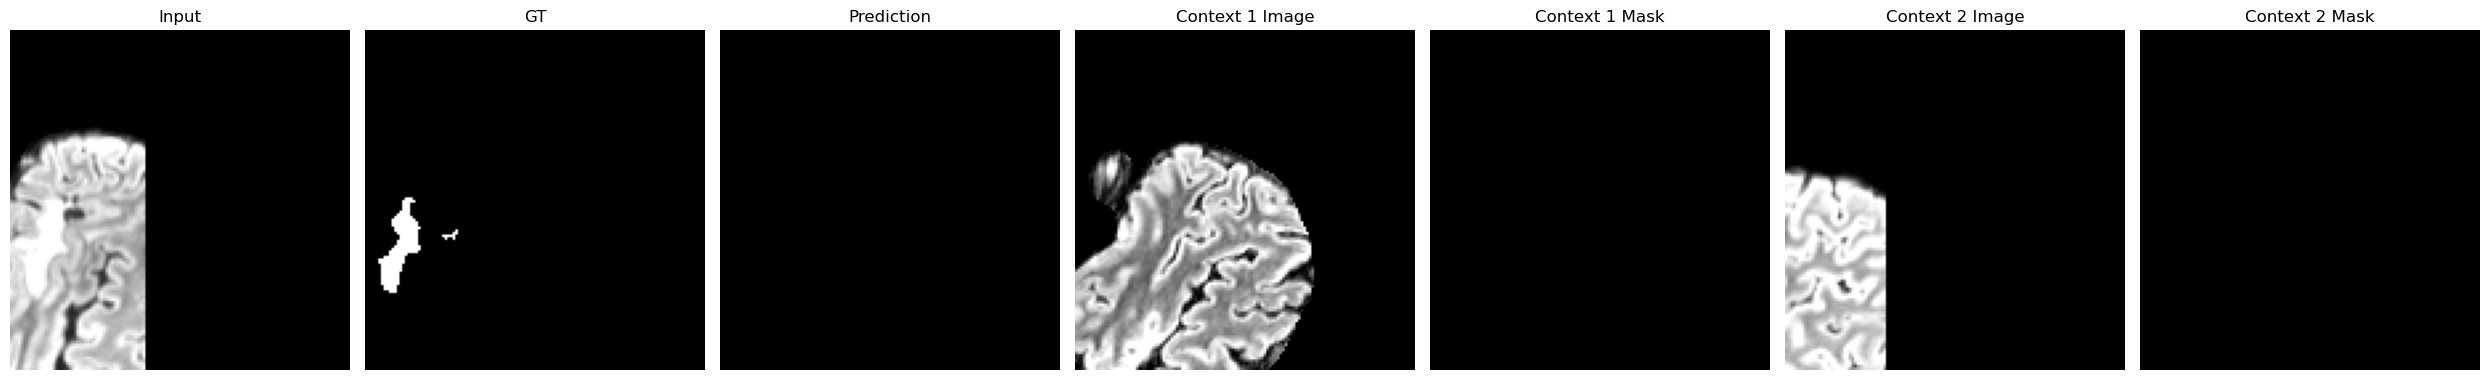

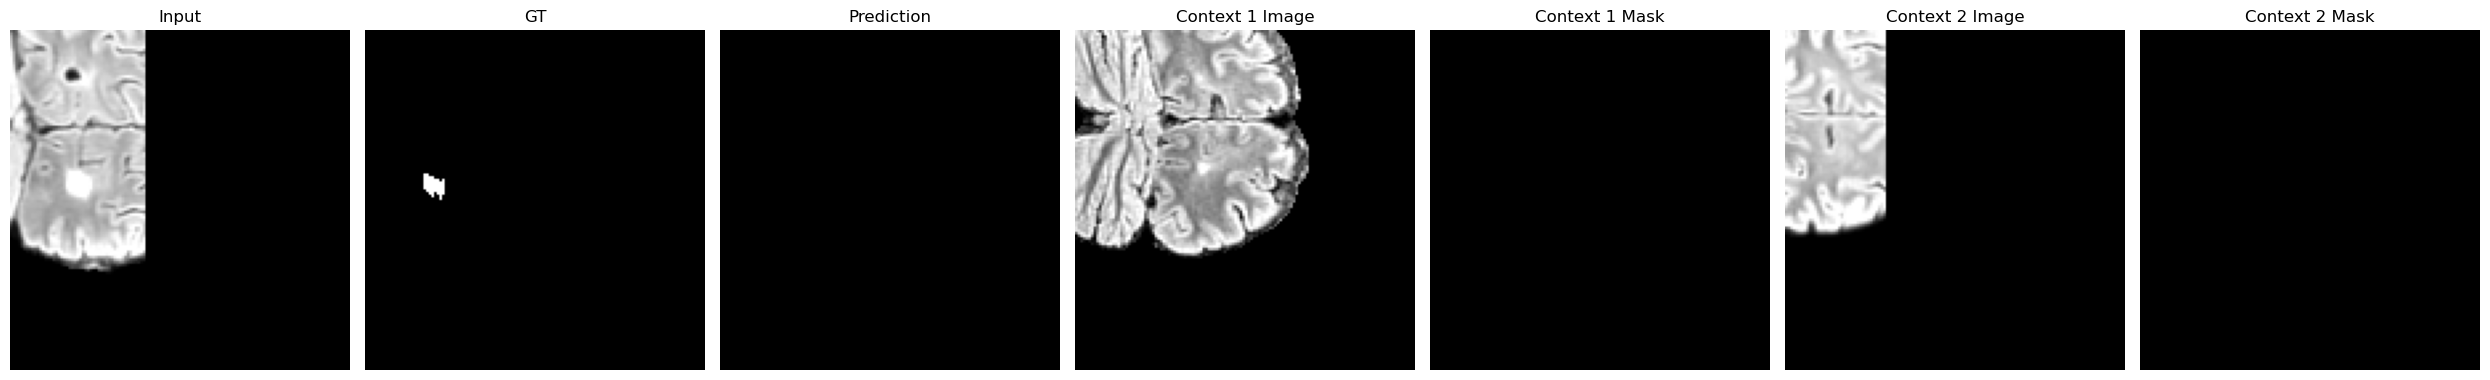

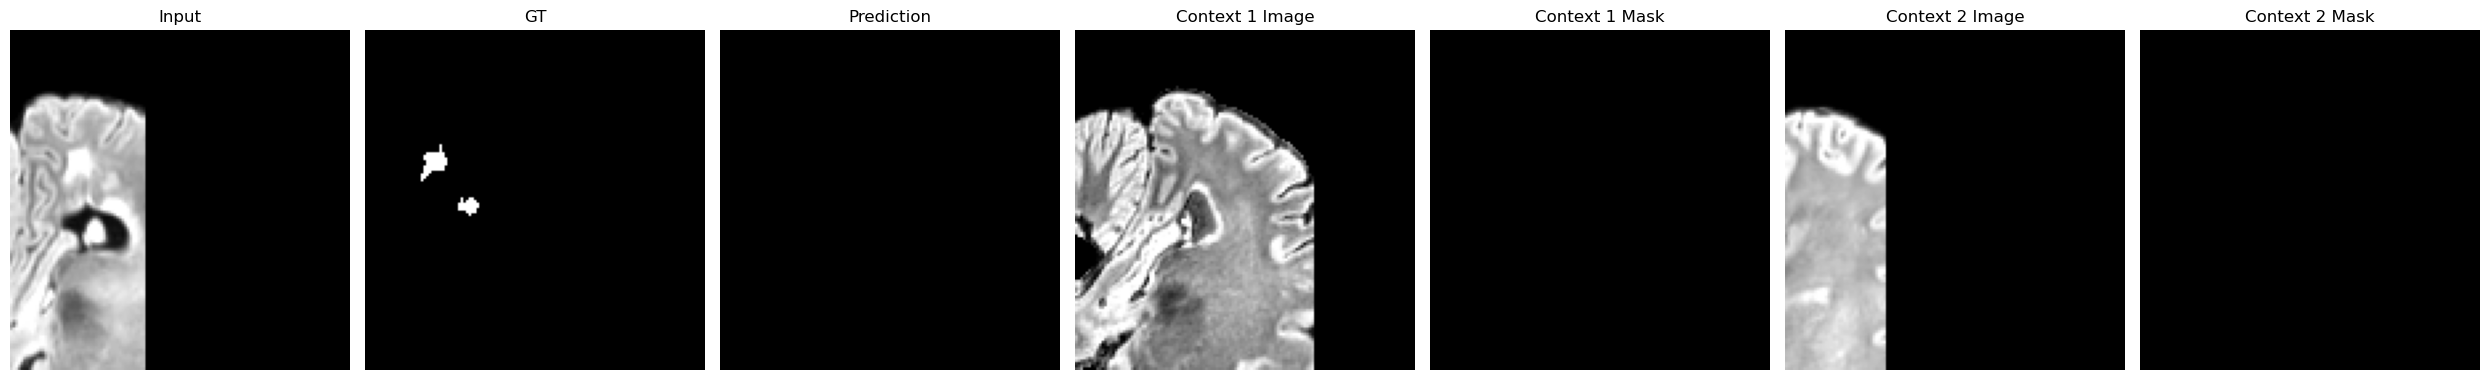

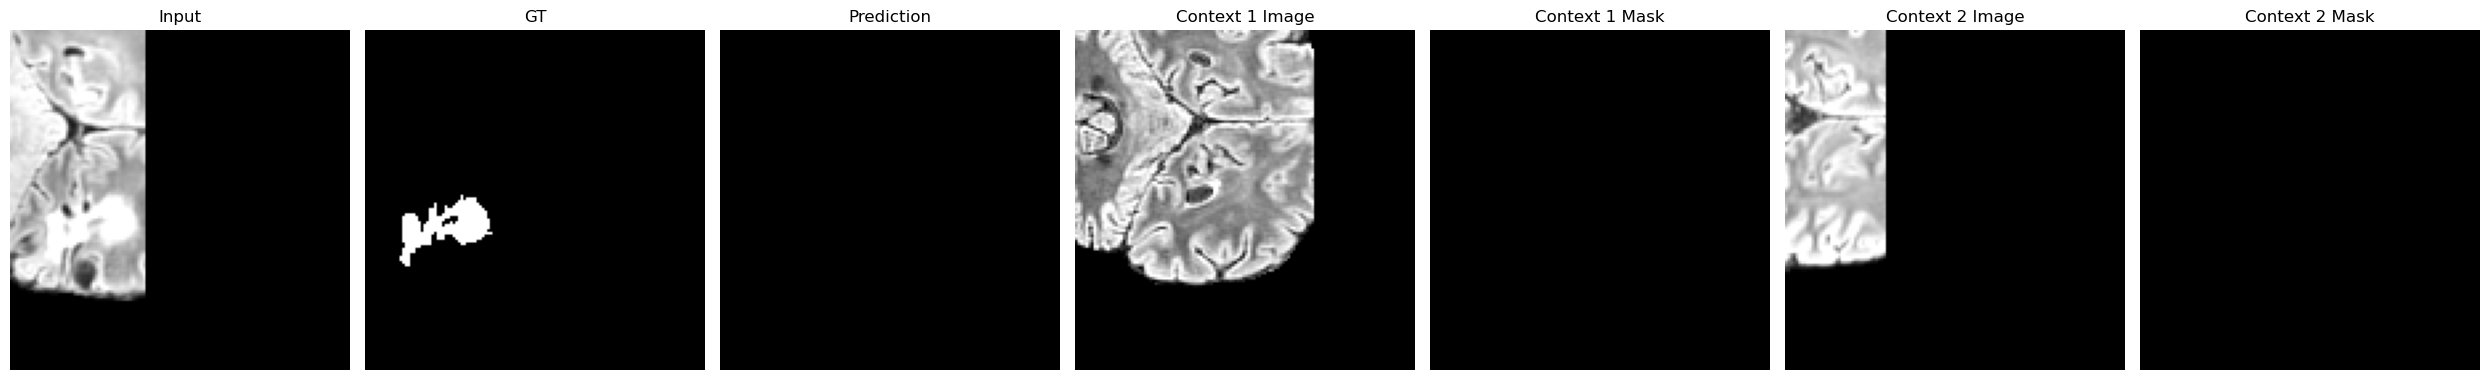

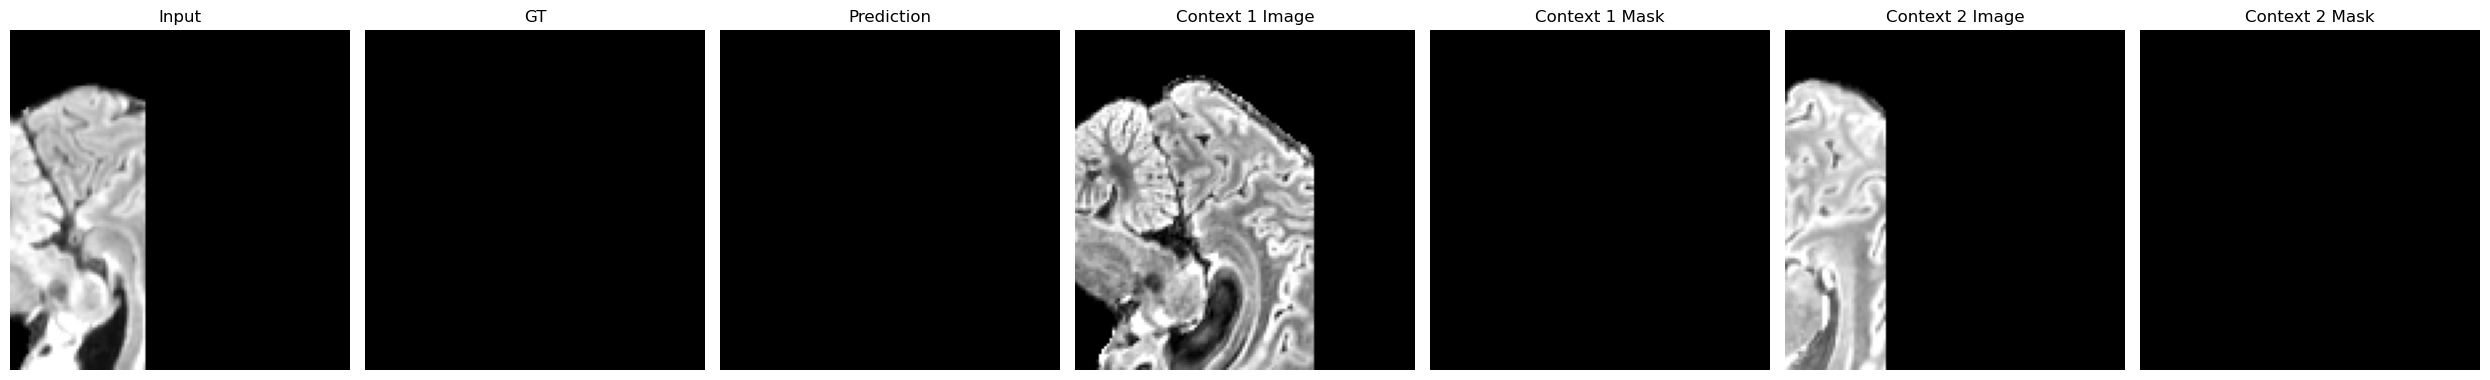

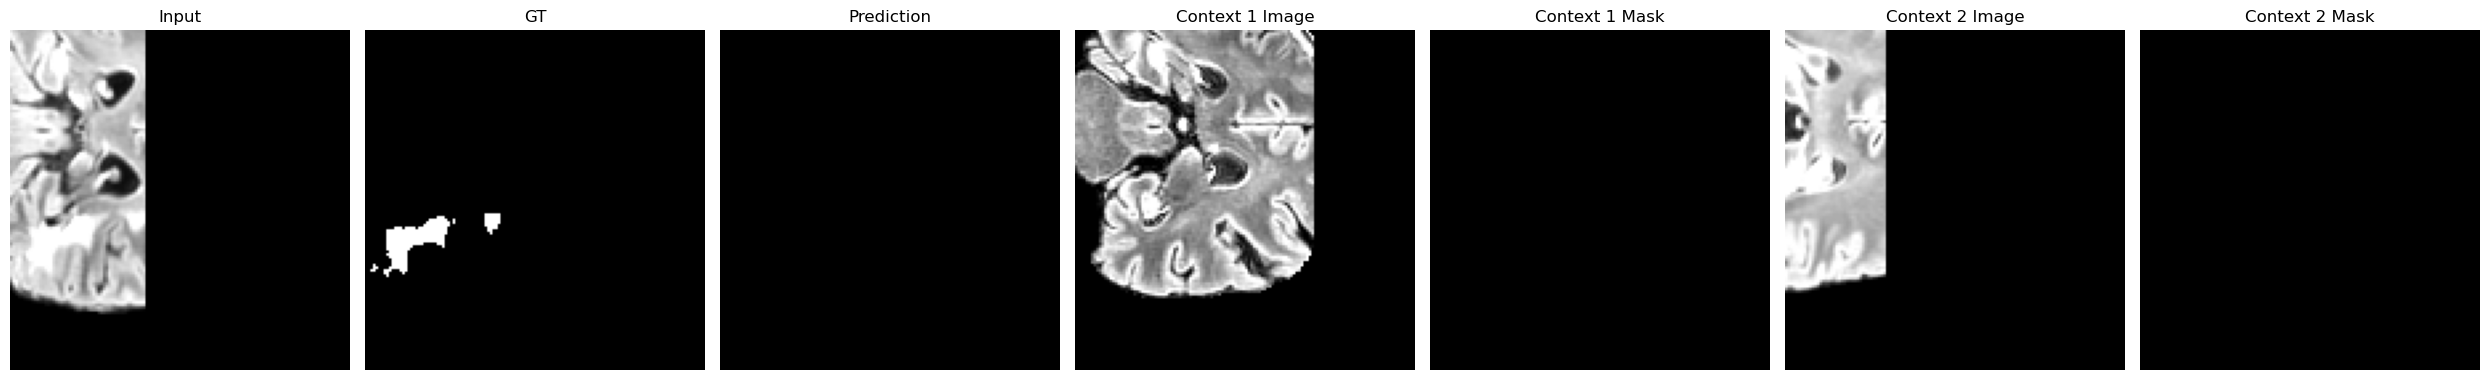

In [7]:
# Set random foreground
unique_masks = np.unique(target_out_raw) 
print('Unique classes in the mask:', unique_masks)

# Feel free to try different segmentation tasks. 
seg_class = 1 #np.random.choice(unique_masks, size=3, replace=False) # randomly select 3 classes
print('Selected classes:',seg_class)

# Set the foreground class to 1
context_out = np.isin(context_out_raw, seg_class).astype(np.float32)
target_out = np.isin(target_out_raw, seg_class).astype(np.float32)

# Normalization
target_out = normalize_3d_volume(torch.tensor(target_out).to(device))
target_in = normalize_3d_volume(torch.tensor(target_in).to(device))
context_in = normalize_3d_volume(torch.tensor(context_in))
context_out = normalize_3d_volume(torch.tensor(context_out))

# Run model
with torch.no_grad():
    mask = model.forward(target_in, context_in, context_out, gs = 2) # gs control the size of mini-context

for slice_ in [44,64,84]:
    plot_pred(target_in, target_out, context_in, context_out, mask, slice_=slice_)
    plot_pred2(target_in, target_out, context_in, context_out, mask, slice_=slice_)

In [9]:
# Convert mask to numpy array if it's a torch tensor
mask_np = mask.cpu().detach().numpy() if hasattr(mask, 'cpu') else mask
# Remove batch dimension 
mask_np = mask_np[0,0]
print(mask_np.shape)
print(np.min(mask_np), np.max(mask_np))
# Threshold: values > 0.5 become 1, else 0
mask_np = (mask_np > 0.5).astype(np.int8)
print(np.unique(mask_np, return_counts=True))

target_out_np = target_out.cpu().detach().numpy()
target_out_np = target_out_np[0,0]
print(target_out_np.shape)
print(np.unique(target_out_np, return_counts=True))
target_out_np = (target_out_np > 0.5).astype(np.int8)
print(np.unique(target_out_np, return_counts=True))

# compute dsc and nsd
sys.path.append("/nfs/norasys/notebooks/camaret/cvpr25/CVPR-MedSegFMCompetition")
from unittest import case
from SurfaceDice import (
    compute_surface_distances,
    compute_surface_dice_at_tolerance,
    compute_dice_coefficient,
)
dsc = compute_dice_coefficient(mask_np, target_out_np)



# Load reference image to get affine
case_num = 'MR_BraTS_0006'
ref_path = img_dir / f'{case_num}_img.nii.gz'
ref_nii = nib.load(ref_path)
affine = ref_nii.affine
surface_distance = compute_surface_distances(mask_np, target_out_np, spacing_mm=np.diag(affine)[:3])
nsd = compute_surface_dice_at_tolerance(surface_distance, tolerance_mm=2.0)
print(f'Dice Similarity Coefficient (DSC): {dsc:.4f}')
print(f'Normalized Surface Dice (NSD): {nsd:.4f}')

(128, 128, 128)
-0.010734916 0.5749444
(array([0, 1], dtype=int8), array([2096901,     251]))
(128, 128, 128)
(array([0., 1.], dtype=float32), array([2082315,   14837]))
(array([0, 1], dtype=int8), array([2082315,   14837]))
Dice Similarity Coefficient (DSC): 0.0000
Normalized Surface Dice (NSD): 0.0000


In [14]:
# write mask to nifti 

# Create NIfTI image with reference affine
mask_nii = nib.Nifti1Image(mask_np, affine=affine)
gt_nii = nib.Nifti1Image(target_out_np, affine=affine)

# Save to file
nib.save(mask_nii, lab_dir / f'{case_num}_pred.nii.gz')
nib.save(gt_nii, lab_dir / f'{case_num}_gt.nii.gz')

# save to nora project 

lab_regex = r"(?<patients_id>[^_]+)_(?<studies_id>\d+)_pred\.nii\.gz"
!nora -p {project_name} --importfiles {lab_dir} '{lab_regex}' --addtag mask
lab_regex = r"(?<patients_id>[^_]+)_(?<studies_id>\d+)_gt\.nii\.gz"
!nora -p {project_name} --importfiles {lab_dir} '{lab_regex}' --addtag mask

searching in /nfs/data/nii/data1/Analysis/camaret___in_context_segmentation/ANALYSIS_20251122/results/MR_BraTS/labs with regexp (?<patients_id>[^_]+)_(?<studies_id>\d+)_pred\.nii\.gz
importing BraTS#0006 file:/nfs/data/nii/data1/camaret___in_context_segmentation/BraTS/0006/MR_BraTS_0006_pred.nii.gz
Finished adding 1 files         
searching in /nfs/data/nii/data1/Analysis/camaret___in_context_segmentation/ANALYSIS_20251122/results/MR_BraTS/labs with regexp (?<patients_id>[^_]+)_(?<studies_id>\d+)_gt\.nii\.gz
importing BraTS#0006 file:/nfs/data/nii/data1/camaret___in_context_segmentation/BraTS/0006/MR_BraTS_0006_gt.nii.gz
Finished adding 1 files         


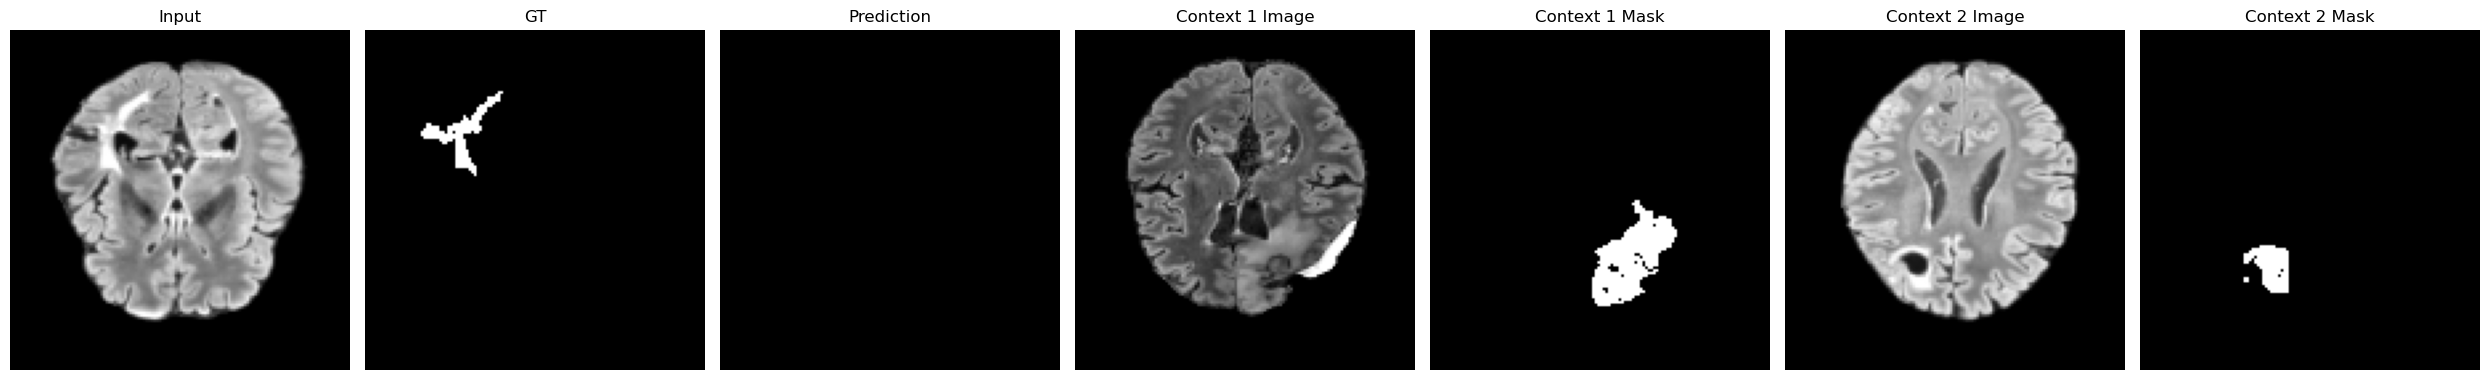

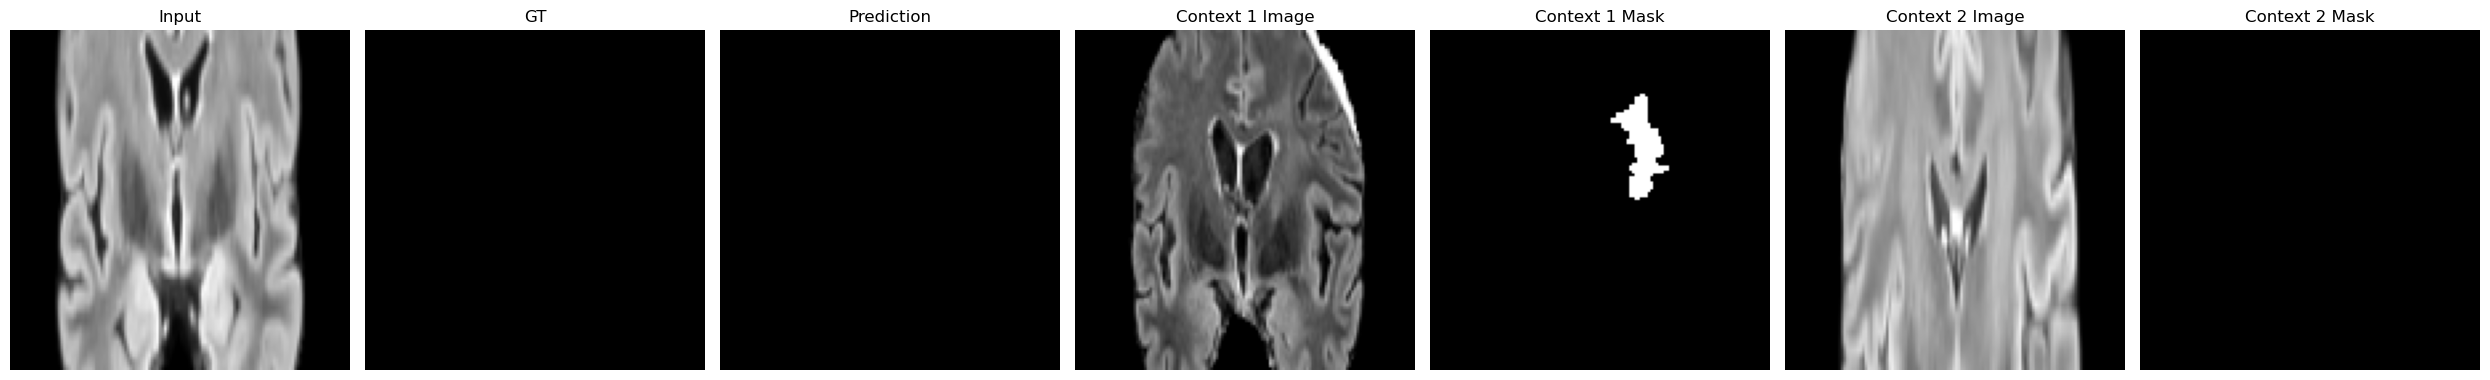

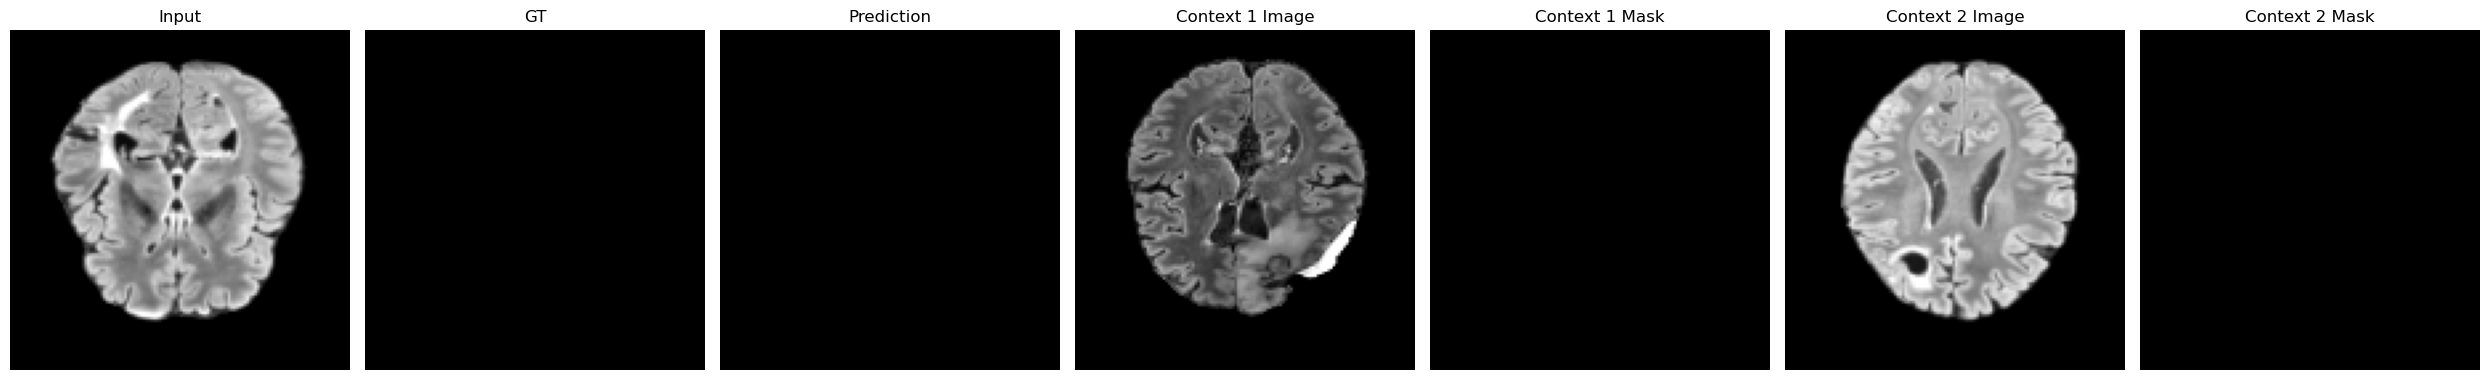

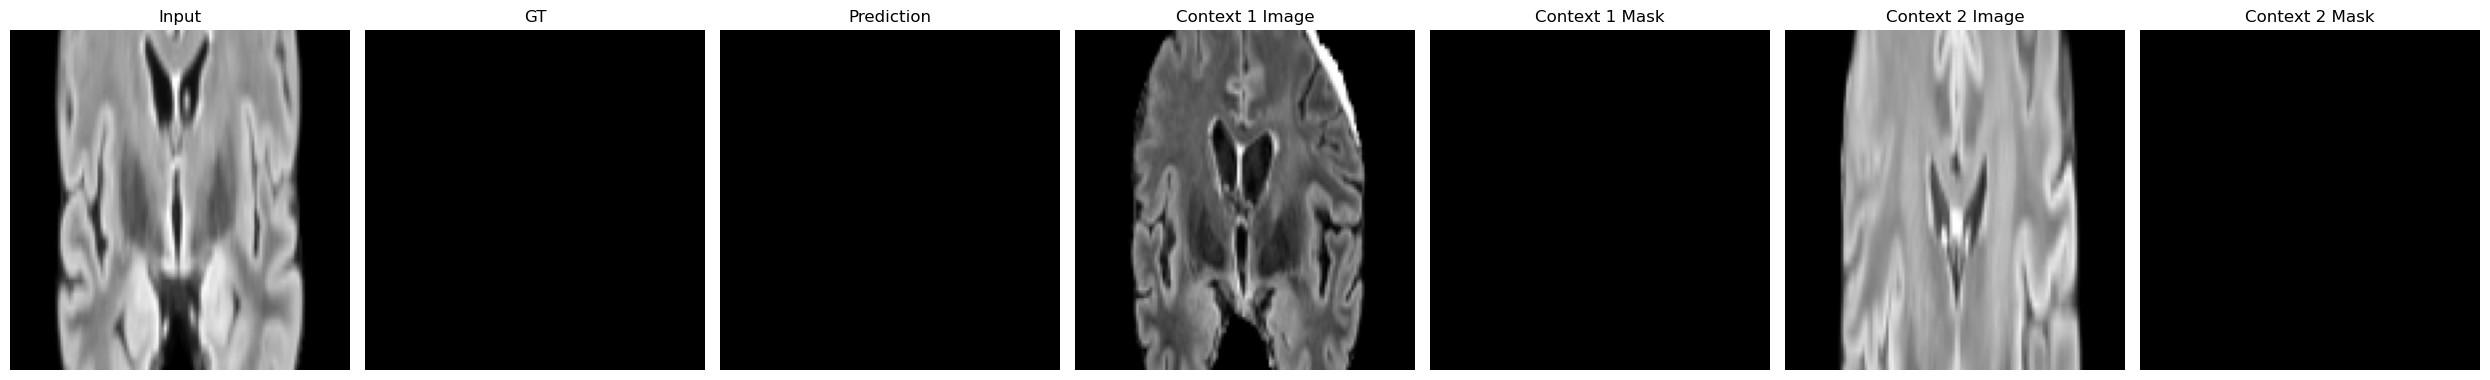

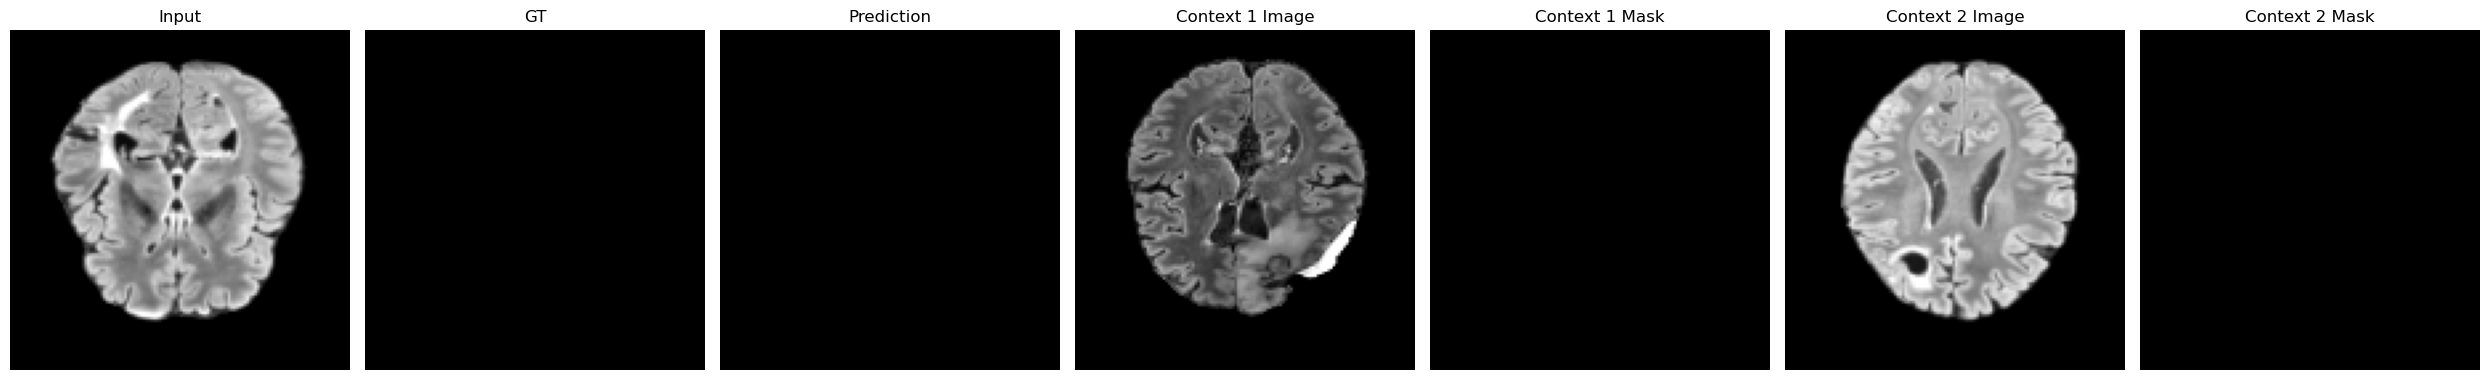

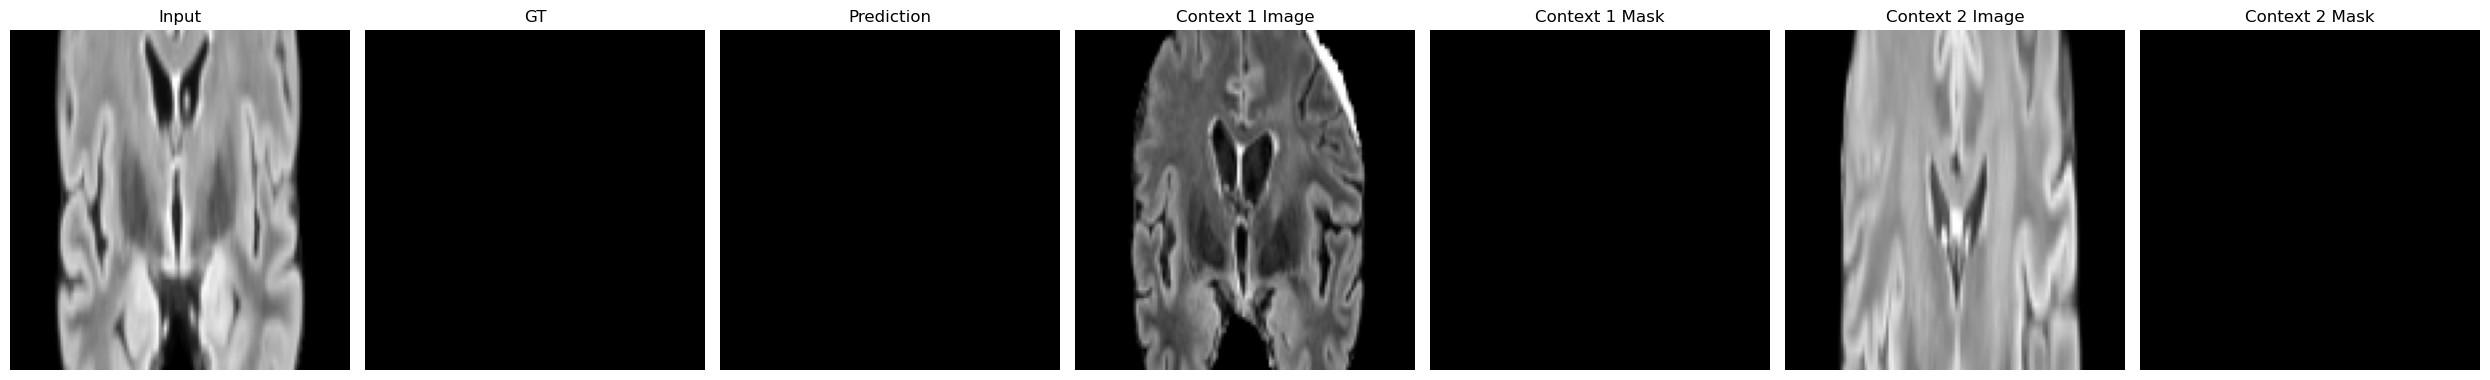

In [27]:
# Evaluation 
for seg_class in [[1,20],[2,21],[7,26]]: # Select foreground class. 
    # Set the foreground class to 1
    context_out = np.isin(context_out_raw, seg_class).astype(np.float32)
    target_out = np.isin(target_out_raw, seg_class).astype(np.float32)

    # Normalization
    target_out = normalize_3d_volume(torch.tensor(target_out).to(device))
    target_in = normalize_3d_volume(torch.tensor(target_in).to(device))
    context_in = normalize_3d_volume(torch.tensor(context_in)) # It is important to keep context in cpu to save memory, when the context size is large.
    context_out = normalize_3d_volume(torch.tensor(context_out))
    
    
    # Run model
    with torch.no_grad():
        mask = model.forward(target_in, context_in, context_out, gs = 2) # gs control the size of mini-context
        
    plot_pred(target_in, target_out, context_in, context_out, mask, slice_=64)
    plot_pred2(target_in, target_out, context_in, context_out, mask, slice_=64)

In [ ]:
# Plotting




import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# plot cases 
for case_num in case_numbers:
    img_file = [f for f in img_cases if case_num in f][0]
    gt_file = [f for f in gt_cases if case_num in f][0]

    img_nii = nib.load(os.path.join(cases_dir, img_file))
    gt_nii = nib.load(os.path.join(cases_dir, gt_file))

    img_data = img_nii.get_fdata()
    gt_data = gt_nii.get_fdata()

    print(f"Case {case_num}: Image shape: {img_data.shape}, GT shape: {gt_data.shape}")
    print(f"classes in GT: {np.unique(gt_data)}")

    # transpose to (H, W, D)
    img_data = np.transpose(img_data, (2, 1, 0))
    gt_data = np.transpose(gt_data, (2, 1, 0))

    # Plot z-middle slice of image and ground truth
    mid_slice = img_data.shape[2] // 2
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img_data[:, :, mid_slice], cmap='gray')
    plt.title(f'Case {case_num} - Image Middle Slice')
    plt.subplot(1, 2, 2)
    plt.imshow(gt_data[:, :, mid_slice], cmap='gray')
    plt.title(f'Case {case_num} - Ground Truth Middle Slice')
    plt.show()  
    
    # Plot y-middle slice of image and ground truth
    mid_slice_y = img_data.shape[1] // 2
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img_data[:, mid_slice_y, :], cmap='gray')
    plt.title(f'Case {case_num} - Image Y-Middle Slice')
    plt.subplot(1, 2, 2)
    plt.imshow(gt_data[:, mid_slice_y, :], cmap='gray')
    plt.title(f'Case {case_num} - Ground Truth Y-Middle Slice')
    plt.show()

    # Plot x-middle slice of image and ground truth
    mid_slice_x = img_data.shape[0] // 2
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img_data[mid_slice_x, :, :], cmap='gray')
    plt.title(f'Case {case_num} - Image X-Middle Slice')
    plt.subplot(1, 2, 2)
    plt.imshow(gt_data[mid_slice_x, :, :], cmap='gray')
    plt.title(f'Case {case_num} - Ground Truth X-Middle Slice')
    plt.show()

# resize to 128x128x128 and store in arrays

from scipy.ndimage import zoom

case_numbers = ['0006', '0009', '0070']

# Initialize arrays
images = np.zeros((3, 1, 128, 128, 128), dtype=np.float32)
labels = np.zeros((3, 1, 128, 128, 128), dtype=np.float32)

# Load and resize each case
for idx, case_num in enumerate(case_numbers):
    # Find matching files
    img_file = [f for f in img_cases if case_num in f][0]
    gt_file = [f for f in gt_cases if case_num in f][0]
    
    # Load nifti files
    img_nii = nib.load(os.path.join(cases_dir, img_file))
    gt_nii = nib.load(os.path.join(cases_dir, gt_file))
    
    img_data = img_nii.get_fdata()
    gt_data = gt_nii.get_fdata()

    img_data = np.transpose(img_data, (2, 1, 0))
    gt_data = np.transpose(gt_data, (2, 1, 0))

    # set all classes >1 to 1 in gt_data
    gt_data[gt_data > 1] = 1

    print(f"classes in GT after thresholding: {np.unique(gt_data)}")

    # Plot a middle slice for verification
    mid_slice = img_data.shape[2] // 2
    plt.imshow(img_data[:, :, mid_slice], cmap='gray')
    plt.title(f'Case {case_num} - Middle Slice')
    plt.show()
    
    # Calculate zoom factors
    zoom_factors = [128 / s for s in img_data.shape]
    
    # Resize to (128, 128, 128)
    img_resized = zoom(img_data, zoom_factors, order=1)
    gt_resized = zoom(gt_data, zoom_factors, order=0)

    # plot resized middle slice for verification
    mid_slice_resized = img_resized.shape[2] // 2
    plt.imshow(img_resized[:, :, mid_slice_resized], cmap='gray')
    plt.title(f'Case {case_num} - Resized Middle Slice')
    plt.show()
    
    # Store in arrays
    images[idx, 0] = img_resized
    labels[idx, 0] = gt_resized

print('Shape of images:', images.shape)
print('Shape of labels:', labels.shape)



Case numbers: ['0006', '0009', '0070', '0107', '0321', '0546', '0703', '0771', '1033', '1096', '1172', '1262']

Images (12): ['MR_BraTS-T2f_bratsgli_0006_img.nii.gz', 'MR_BraTS-T2f_bratsgli_1262_img.nii.gz', 'MR_BraTS-T2f_bratsgli_0703_img.nii.gz', 'MR_BraTS-T2f_bratsgli_0070_img.nii.gz', 'MR_BraTS-T2w_bratsgli_0771_img.nii.gz', 'MR_BraTS-T2f_bratsgli_1033_img.nii.gz', 'MR_BraTS-T2f_bratsgli_0546_img.nii.gz', 'MR_BraTS-T2f_bratsgli_0009_img.nii.gz', 'MR_BraTS-T2f_bratsgli_1096_img.nii.gz', 'MR_BraTS-T2w_bratsgli_0321_img.nii.gz', 'MR_BraTS-T2f_bratsgli_1172_img.nii.gz', 'MR_BraTS-T2f_bratsgli_0107_img.nii.gz']

Ground truths (12): ['MR_BraTS-T2f_bratsgli_0546_gt.nii.gz', 'MR_BraTS-T2f_bratsgli_0070_gt.nii.gz', 'MR_BraTS-T2f_bratsgli_0006_gt.nii.gz', 'MR_BraTS-T2f_bratsgli_1096_gt.nii.gz', 'MR_BraTS-T2w_bratsgli_0321_gt.nii.gz', 'MR_BraTS-T2w_bratsgli_0771_gt.nii.gz', 'MR_BraTS-T2f_bratsgli_0009_gt.nii.gz', 'MR_BraTS-T2f_bratsgli_0703_gt.nii.gz', 'MR_BraTS-T2f_bratsgli_1033_gt.nii.gz', 